In [21]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
import requests
import time
import coolors
from IPython.core.display import display, HTML, clear_output
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
import nest_asyncio
from multiprocessing import cpu_count ,Pool, sharedctypes
import itertools
import tqdm

init_size = plt.rcParams["figure.figsize"]

In [2]:
def imshow(*args, scale =1 ):
    rgb_imgs = [cv2.cvtColor(img,cv2.COLOR_BGR2RGB) for img in args]
    complete_img = np.hstack(tuple(rgb_imgs))
    plt.rcParams["figure.figsize"] = [scale * i for i in init_size ]
    plt.imshow(complete_img)
    plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
    plt.show()
    
def print_progress(amnt):
    clear_output(wait = True)
    print(f"{'%.2f'%(100* amnt)}%")

def disp_color(color):
    return f'<div style = "width: 100px; height:100px; background-color:{color}">{color}</div>'

def display_colors(colors):
    color_html="".join([disp_color('#'+color) for color in hex_colors])
    color_html = f'<div style = " display: flex;">{color_html}</div>'
    display(HTML(color_html))
    
    
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


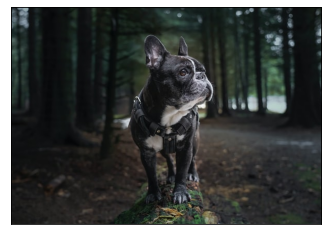

In [12]:
# pulls a random image from unspalsh by changing size and theme can change what image is pulled
size = '600x420'
theme = 'dog forest'
url=f'https://source.unsplash.com/{size}/?{theme}'
resp = requests.get(url, stream=True).raw
img = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(img, cv2.IMREAD_COLOR)

imshow(img)

In [13]:
#apply the nord color scheme (its a scheme I really like) you can modify this my just replacing the colors in this list
hex_colors = ['2e3440','3b4252','434c5e','4c566a','d8dee9','e5e9f0','eceff4','8fbcbb','88c0d0','81a1c1','5e81ac','bf616a','d08770','ebcb8b','a3be8c','b48ead']
display_colors(hex_colors)

In [17]:
#convert hex to rgb
rgb_color_scheme= [hex_to_rgb(color) for color in hex_colors]
#convert rgb to Color Objects 
srgb_color_scheme = [sRGBColor(*color,True) for color in rgb_color_scheme]
#convert srgb to LAB
lab_color_scheme = [convert_color(color, LabColor) for color in srgb_color_scheme ]

[21.60499522  0.69359312 -8.34869105] [29.41176471 -8.          1.        ]
[ 27.94065705   1.31567093 -10.55842854] [29.41176471 -8.          1.        ]
[ 32.19122118   1.05234085 -11.74666582] [29.41176471 -8.          1.        ]
[ 36.42811923   1.14491754 -12.7797616 ] [29.41176471 -8.          1.        ]
[ 8.83160489e+01  5.00715525e-02 -6.07385978e+00] [29.41176471 -8.          1.        ]
[ 9.22325297e+01 -5.32550079e-02 -3.86061960e+00] [29.41176471 -8.          1.        ]
[ 9.43539348e+01 -9.34926827e-02 -2.76552314e+00] [29.41176471 -8.          1.        ]
[ 73.1496868  -15.02623917  -4.36444862] [29.41176471 -8.          1.        ]
[ 74.49946711 -14.1900923  -13.83156074] [29.41176471 -8.          1.        ]
[ 64.96740183  -3.27032079 -20.02635596] [29.41176471 -8.          1.        ]
[ 53.01276684  -0.51514358 -26.65024749] [29.41176471 -8.          1.        ]
[52.5848402  38.49811769 12.42339643] [29.41176471 -8.          1.        ]
[63.26841028 25.37595793 23.921

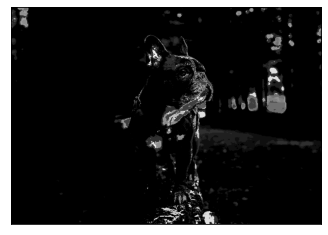

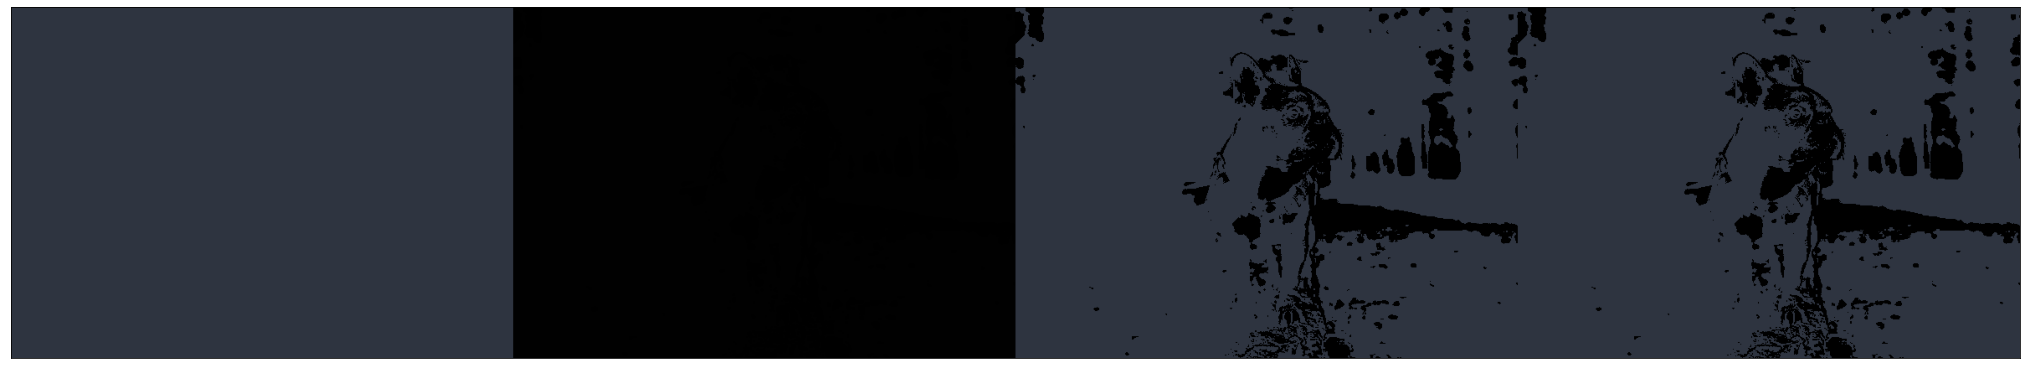

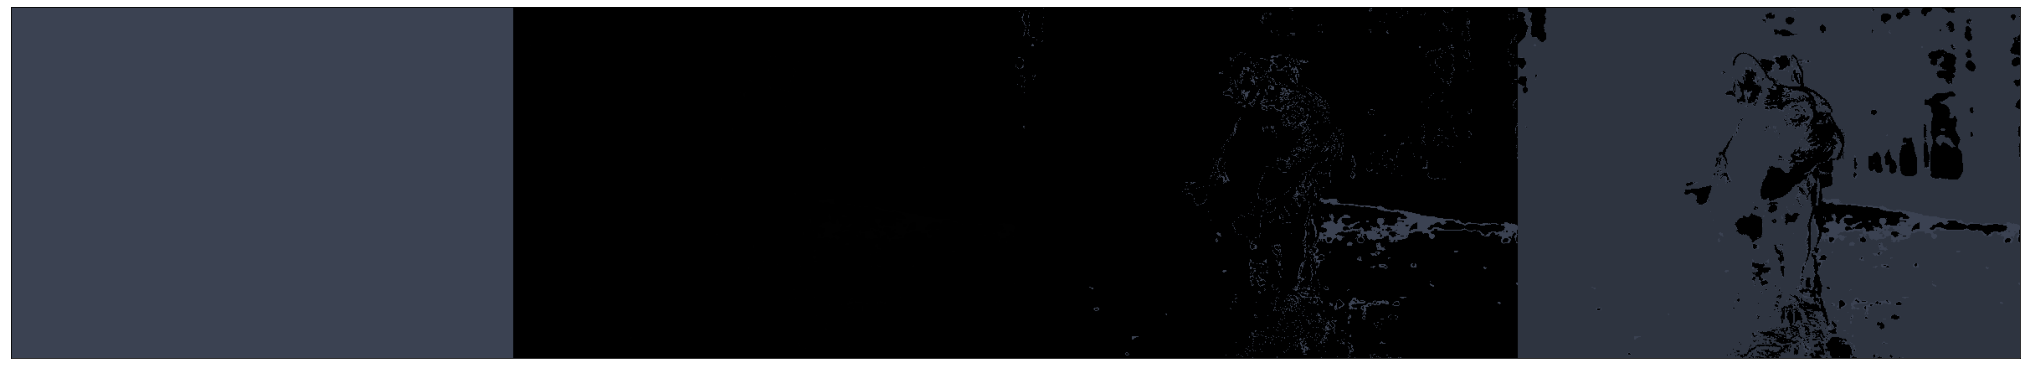

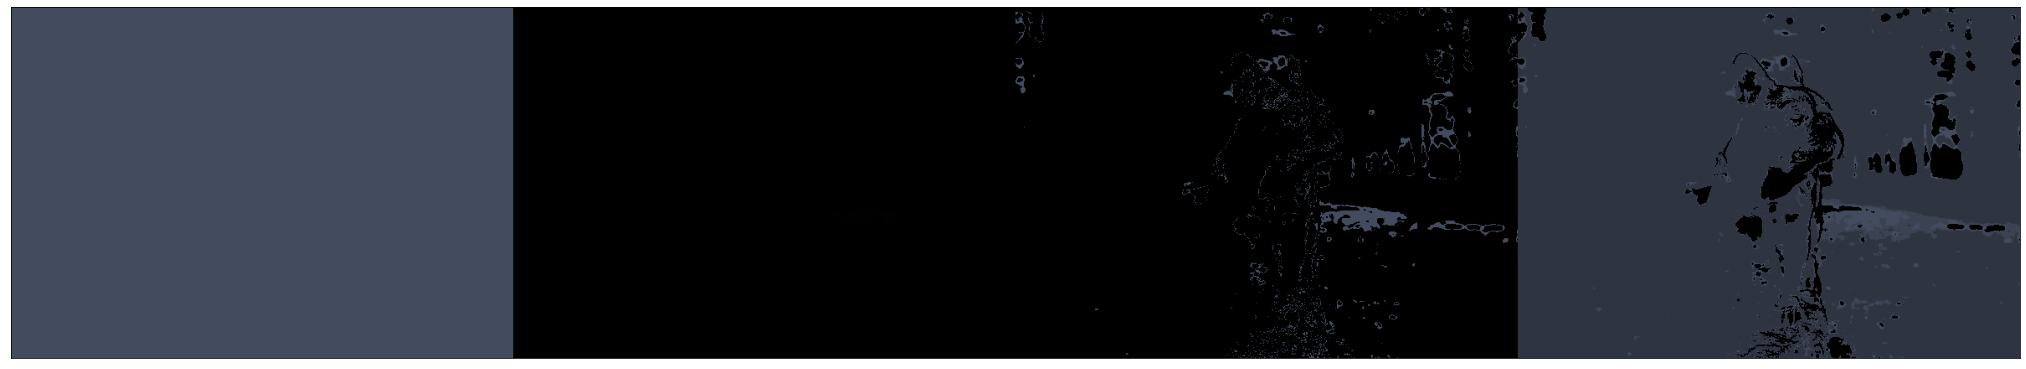

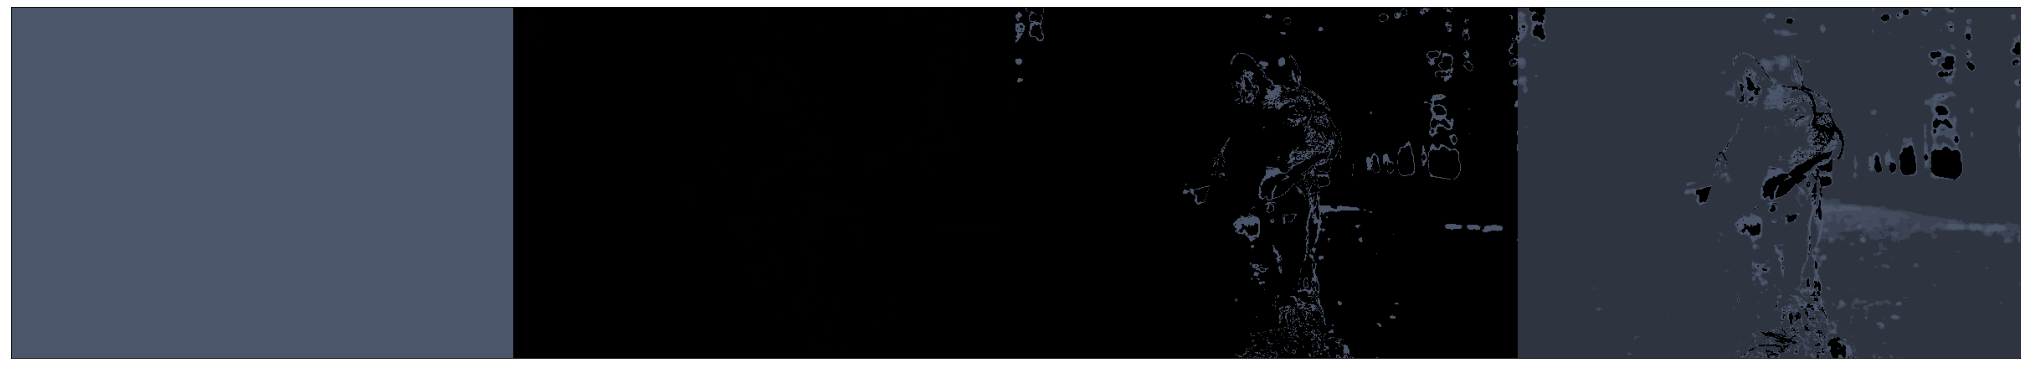

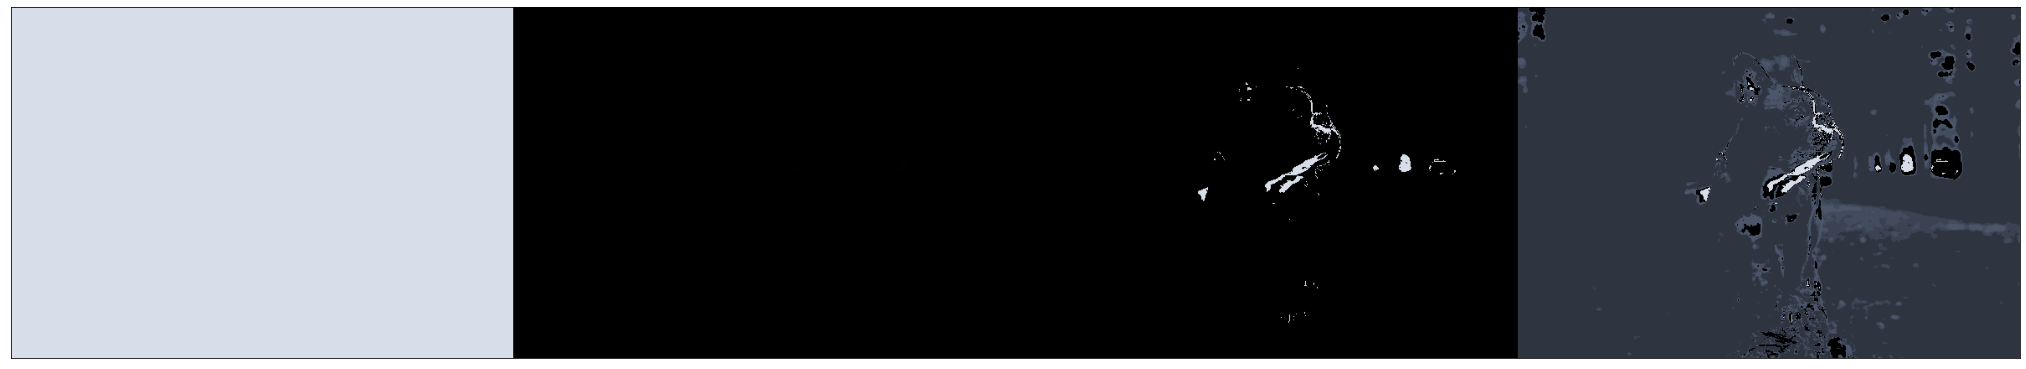

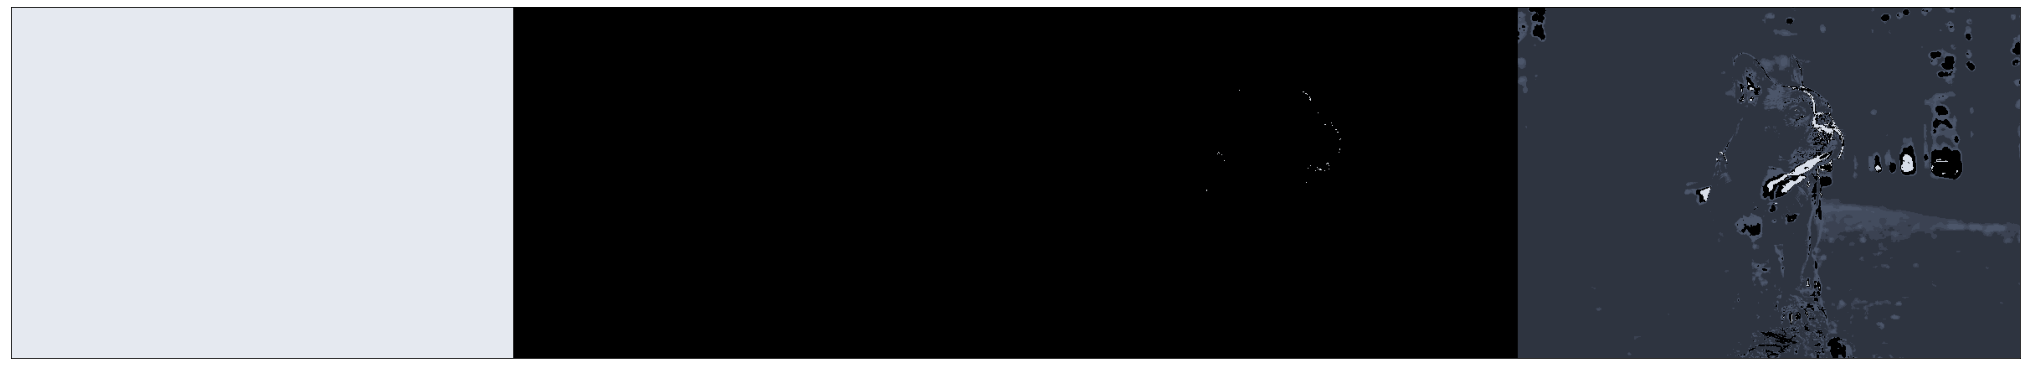

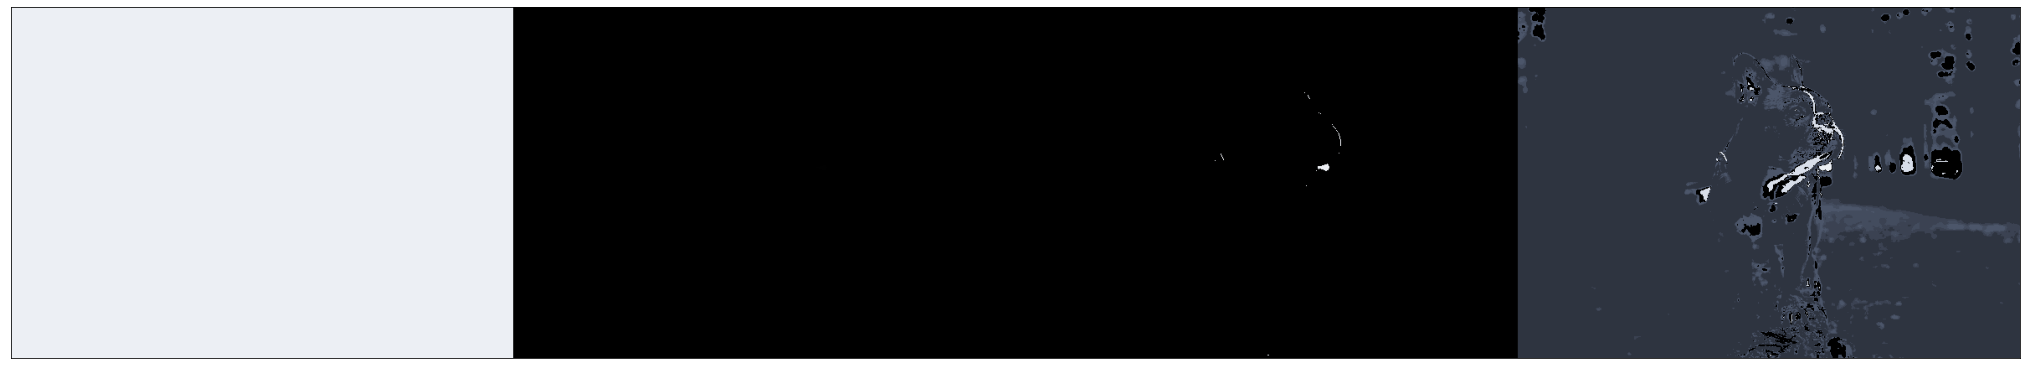

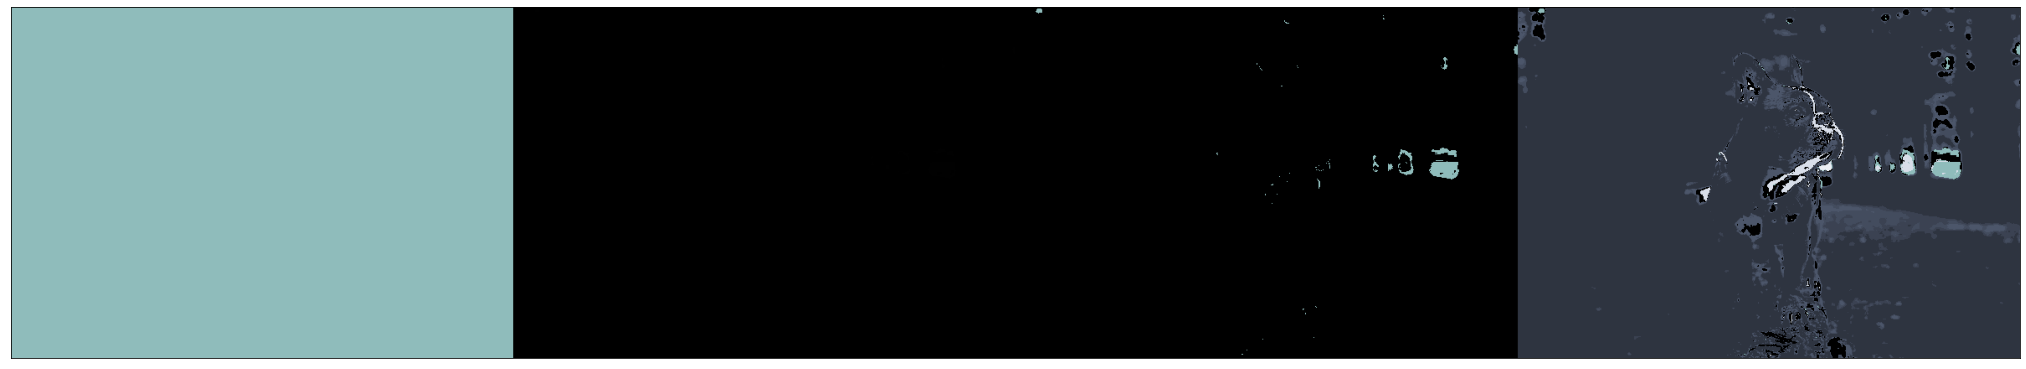

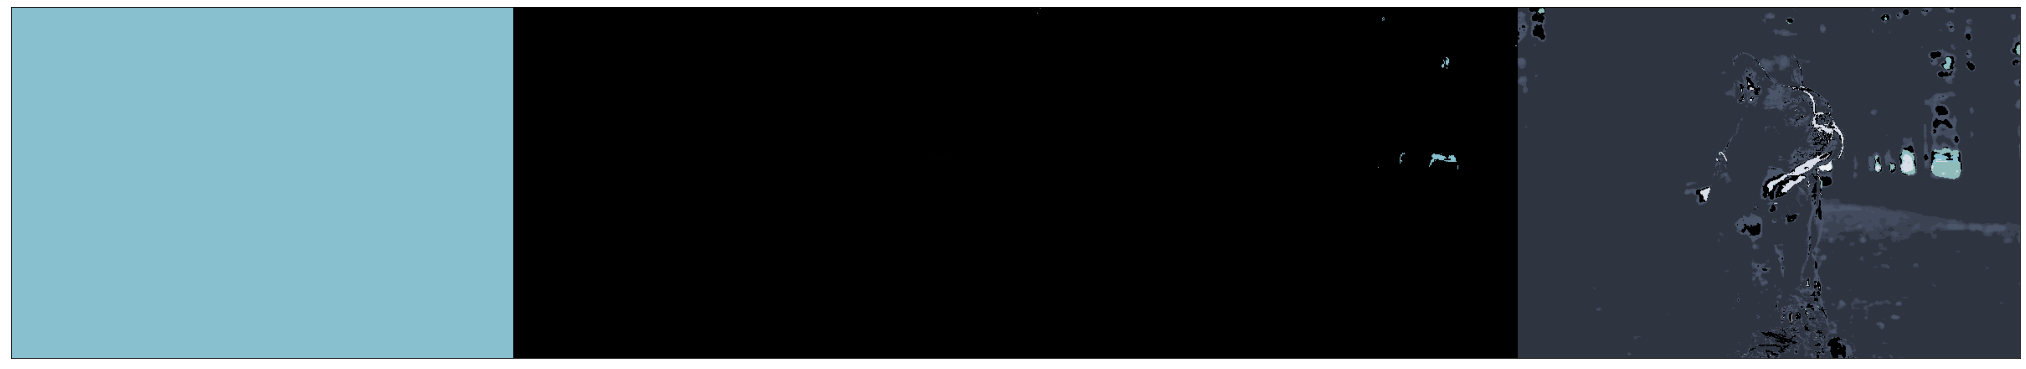

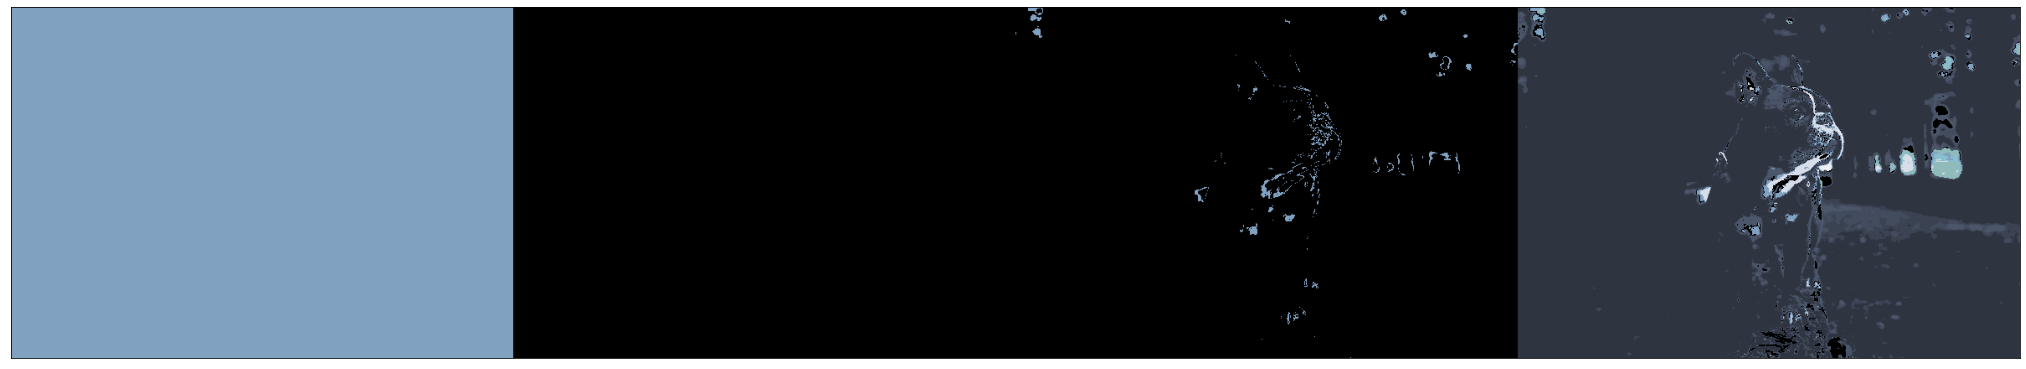

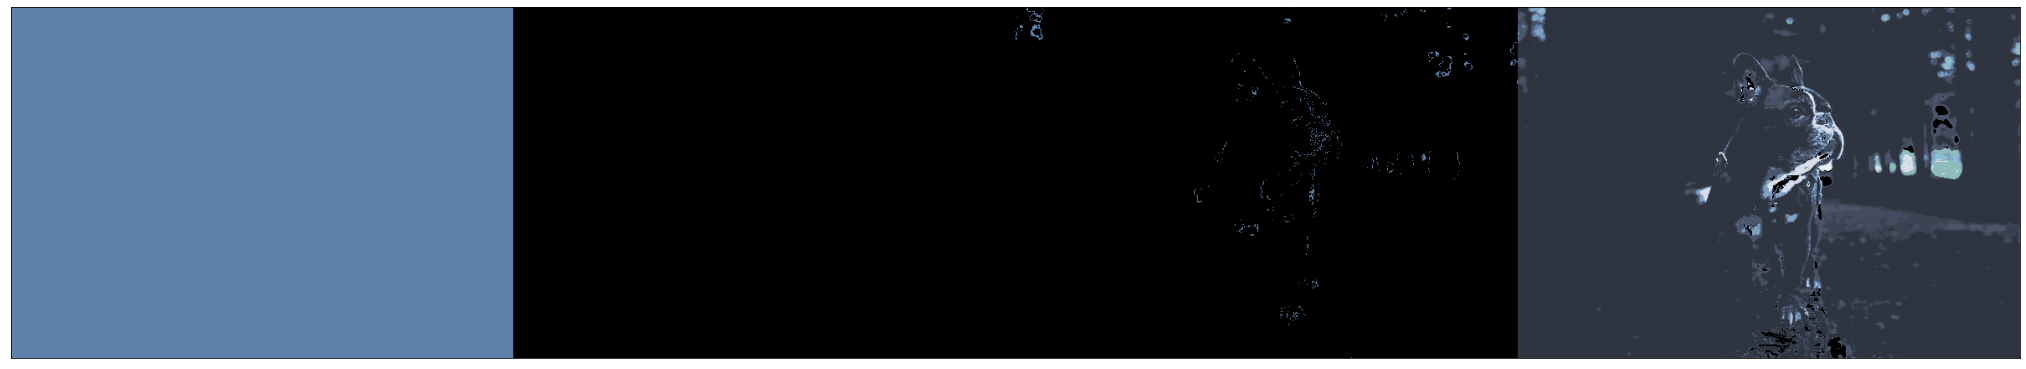

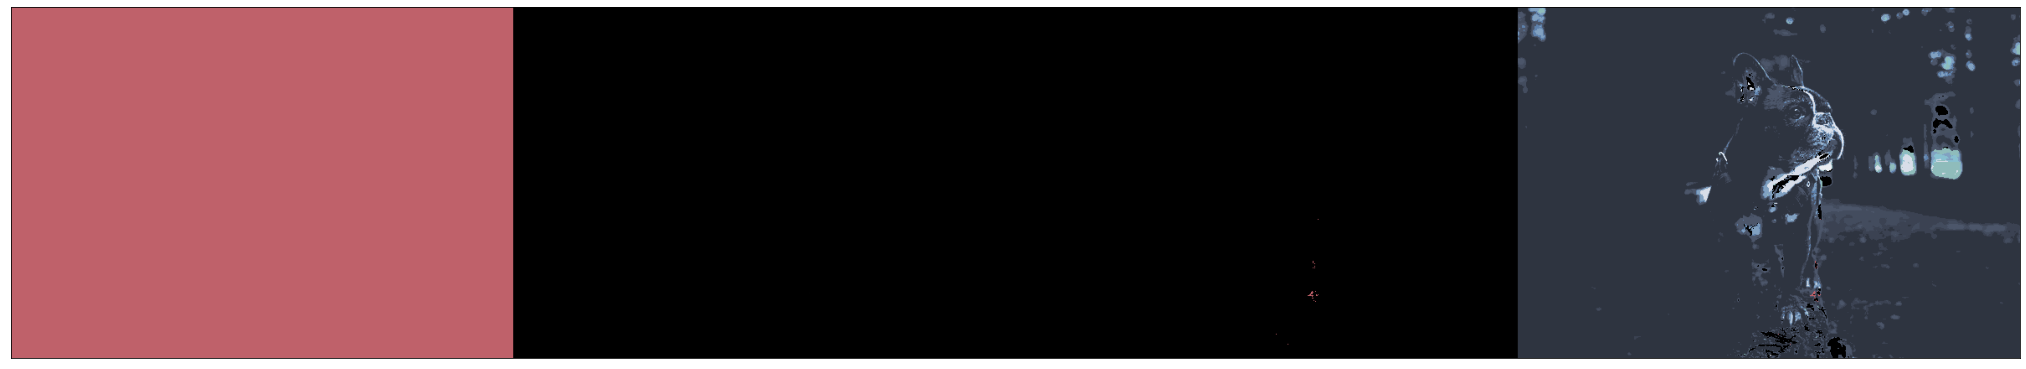

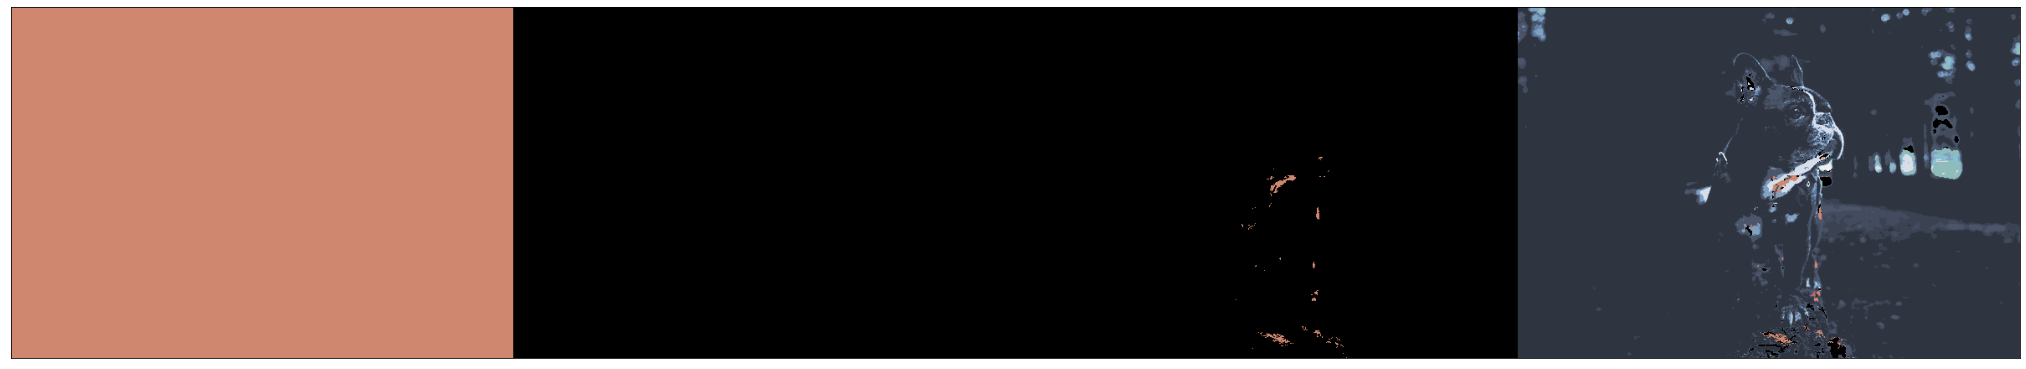

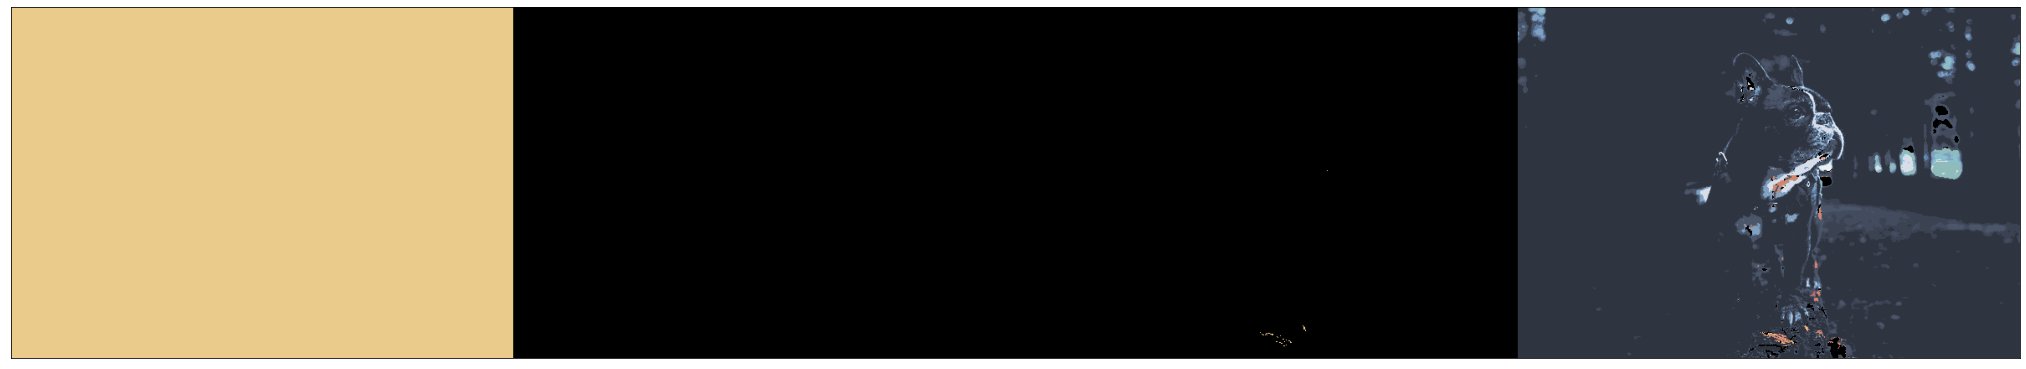

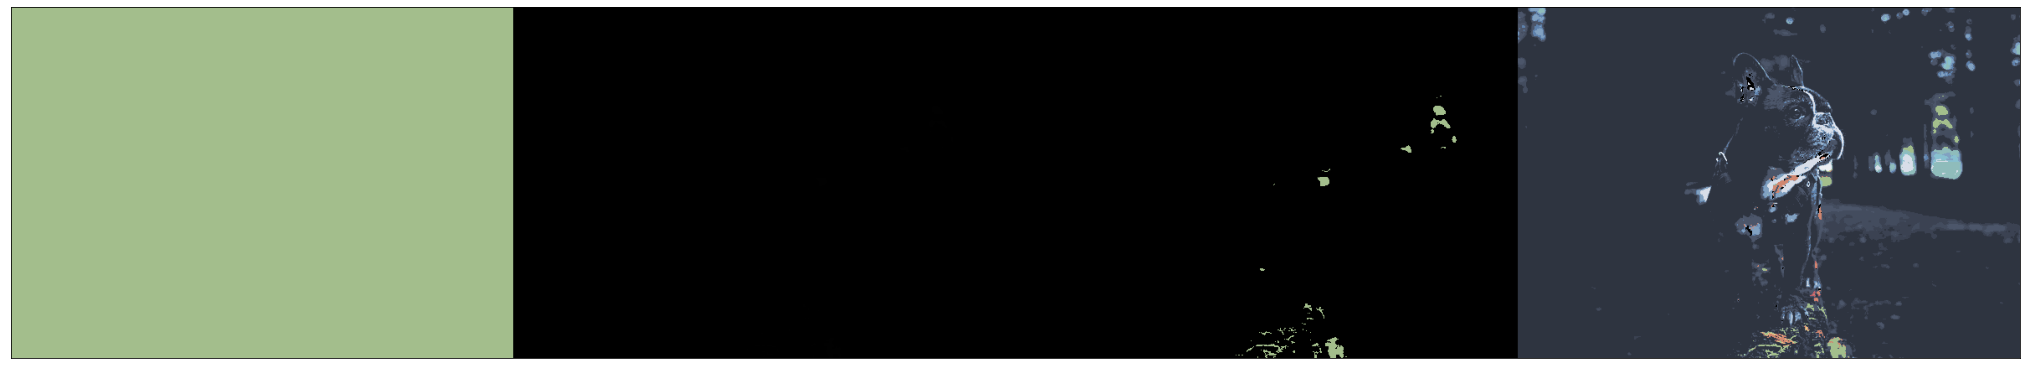

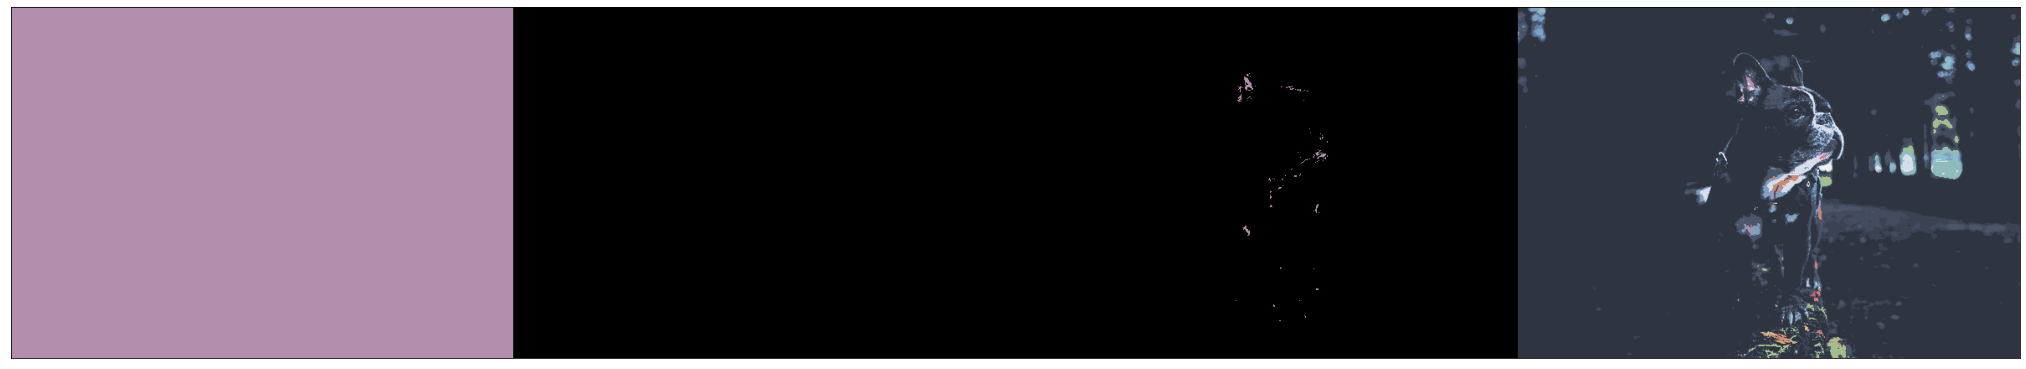

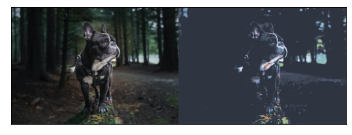

In [37]:
# much faster way of doing the color calcs 
from colormath.color_diff_matrix import delta_e_cie2000

#convert to lab color space
lab_img = cv2.cvtColor(img,cv2.COLOR_BGR2Lab)
L,a,b = cv2.split(lab_img.astype('int32'))
# adjust so its actually lab
L = L*100/255
a = a -128
b = b -128
# re stack the image
lab_img = np.stack((L,a,b),2)
# make into a list and store the shape of the image
pixel_list = lab_img.reshape(-1,3)
shape = lab_img.shape[0:2]
dists = []
for color in lab_color_scheme:
    # get lab color were comparing to 
    lab_vector = np.array(color.get_value_tuple())
    # generate a difference map of the two lab colors using the delta_e function
    dist = delta_e_cie2000(lab_vector, pixel_list)
    dists.append(dist.reshape(shape))
# stack all the differences   
color_vals = np.stack(dists,2)
#find the indexes of the smallest vals
color_idx = np.argmin(color_vals,2)
#show grey scale version of image darker is first color lighest is las
color_disp = color_idx * 255 / len(rgb_color_scheme)
imshow(color_disp.astype('uint8'))
# make new empty image
palleted_img = np.zeros(img.shape,'uint8')

for i, color in enumerate(rgb_color_scheme):
    bgr = tuple(reversed(color))
    # find all pixels that are of this color and make a mask
    mask = np.where(color_idx == i, 1,0)
    mask = mask.astype('uint8')
    # make a image of all one color the same size as the previous one
    color = np.zeros(palleted_img.shape)
    color[:]=bgr
    # preform a mask of the colored image and the mask
    out = cv2.bitwise_and(color, color, mask = mask)
    # add the colors to ourr final image
    palleted_img += out
    # show progress
    imshow(color,mask,out,palleted_img,scale=6)
    
imshow(img,palleted_img, scale = 8)    

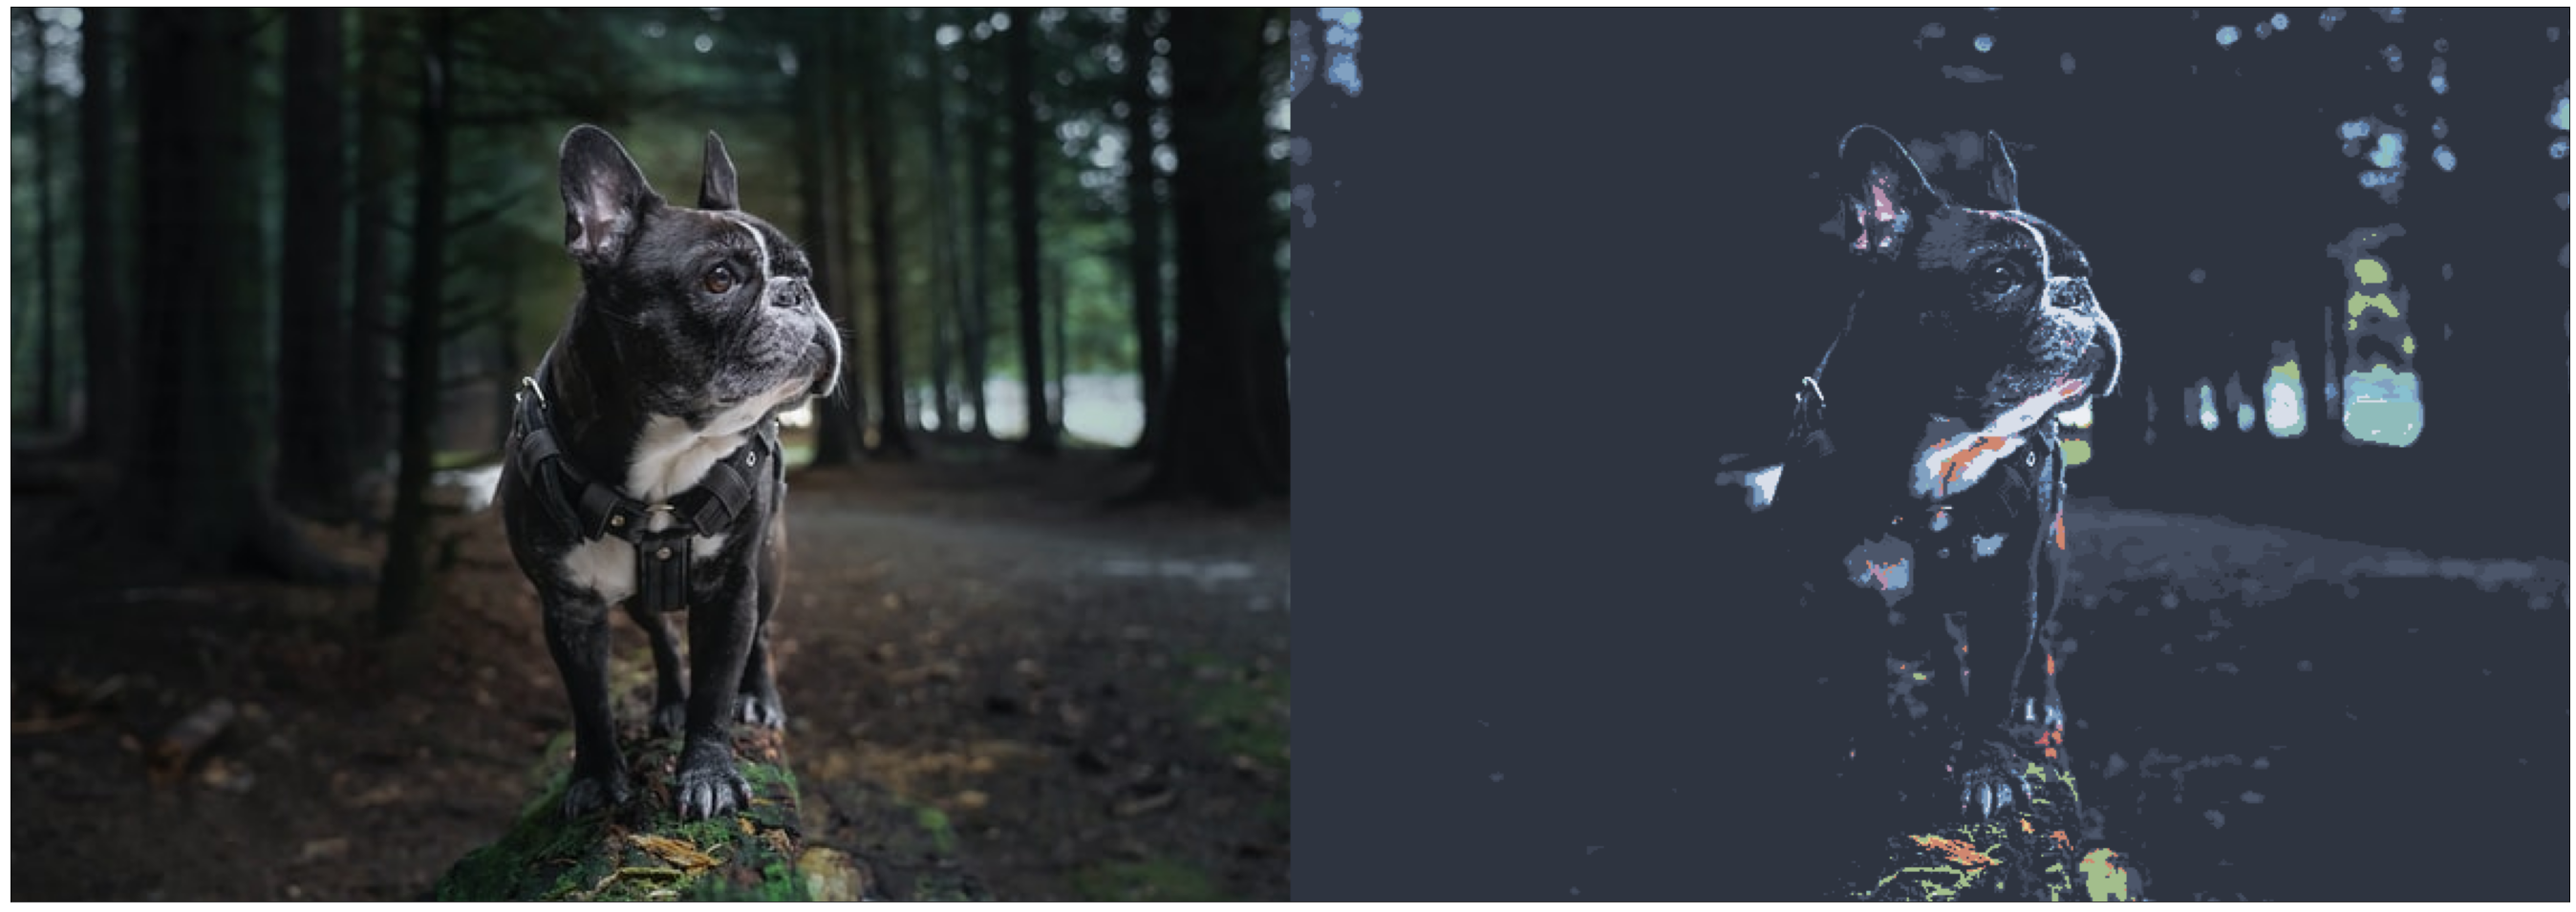

In [38]:
#shows color pallete and before and after image
display_colors(hex_colors)
imshow(img,palleted_img,scale=8)

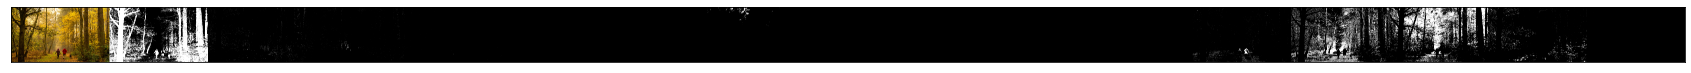

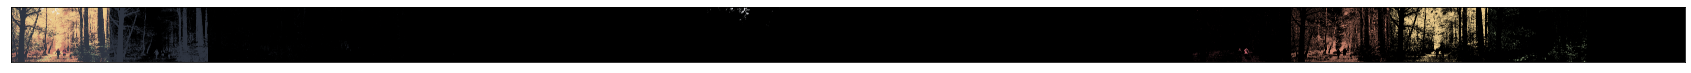

In [52]:
#break up each image into a set of x masks 1 for each color in our color pallete
masks = [img]
outputs = [palleted_img]
for color in rgb_color_scheme: 
    
    color = list(color)
    color.reverse()
    lower = np.array(color, dtype = "uint8")
    upper = np.array(color, dtype = "uint8")
    
    mask = cv2.inRange(palleted_img, lower, upper)
    output = cv2.bitwise_and(palleted_img, palleted_img, mask = mask)
    
    masks.append(mask)
    outputs.append(output)
    
imshow(*masks, scale = 5)
imshow(*outputs, scale = 5)

100%|██████████| 252000/252000 [01:58<00:00, 2121.08it/s]


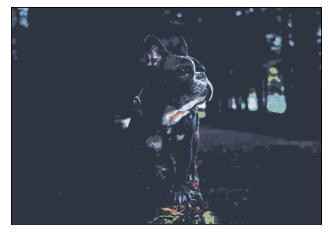

In [30]:
from colormath.color_diff import delta_e_cie2000
h = img.shape[0]
w = img.shape[1]

# make a copy of the image with all zeros in it to write our new image into 
palleted_img = np.ctypeslib.as_ctypes(np.zeros(img.shape,'uint8'))

shared_img = sharedctypes.RawArray(palleted_img._type_, palleted_img)


# function to convert and set one pixel
def palletification(pixel):
        i,j = pixel
        
        tmp = np.ctypeslib.as_array(shared_img)
        
        bgr = img[i,j,:]
        
        #converts bgr to lab
        srgb = sRGBColor(bgr[2],bgr[1],bgr[0],True)
        lab = convert_color(srgb, LabColor)
        
        # checks each color in our color pallete for the closest color
        arr = [delta_e_cie2000(lab, color) for color in lab_color_scheme]
        idx = np.where(arr == np.min(arr))[0][0]
        closest = rgb_color_scheme[idx]
        # sets creates a new image with our colors
        tmp[i,j,0] = closest[2]
        tmp[i,j,1] = closest[1]
        tmp[i,j,2] = closest[0]

with Pool(cpu_count()) as p:
    global img
    pixels = [(i, j) for i, j in
               itertools.product(range(h),
                                 range(w))]
    res = list(tqdm.tqdm(p.imap(palletification,pixels), total=len(pixels)))
palleted_img = np.ctypeslib.as_array(shared_img)
    
imshow(palleted_img)

In [139]:
# generates a random color scheme by scraping https://coolors.co
try:
    nest_asyncio.apply()
    hex_colors = coolors.generate()
except:
    #fall back incase somethings wrong with my package
    hex_colors = ['edafb8','f7e1d7','dedbd2','b0c4b1','4a5759']
display_colors(hex_colors)